
# **Adversarial attacks on face recognition with genetic algorithms**  

In this notebook, we address the adversarial attacks on face recognition systems.

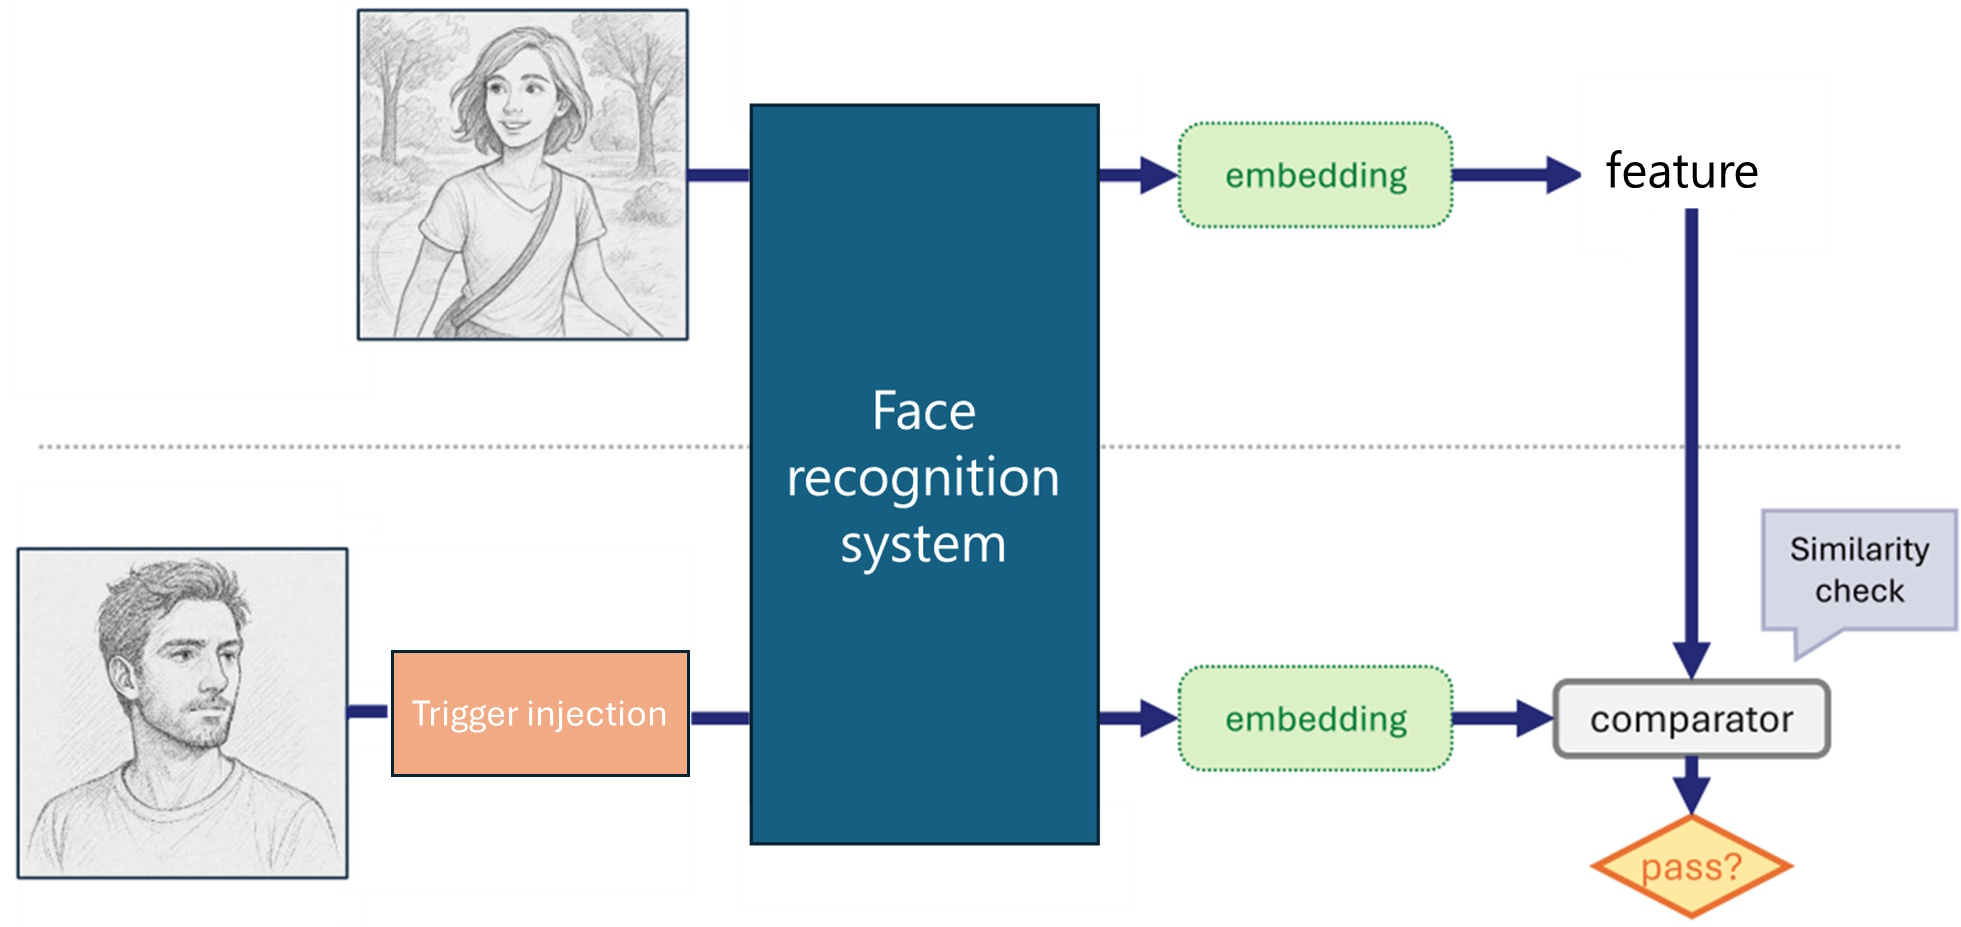

Vinicius **MOREIRA NASCIMENTO** </br>
ENSICAEN Ing Infor 3A – CyIA </br>
IA pour la Sécurité des Systèmes </br>
5 jan 26 </br>

---

**A – Define what is an adversarial attack in AI**

An adversarial attack is a technique that introduces deliberate and carefully crafted modifications in the input data in order to change the behaviour of an AI model. These attacks exploit the internal logic of the model, in particular its decision boundaries, without necessarily changing the semantic meaning of the input for a human observer. The objective is to force the model to produce an incorrect or misleading output while keeping the perturbation as small or as realistic as possible.

**B – What are the main benefits of a genetic algorithm?**

Genetic Algorithms (GAs) present several important advantages. They have strong global search capabilities and are less likely to get stuck in local optima when compared to gradient-based methods. They are broadly applicable to many optimisation problems, including black-box scenarios where the internal structure of the model is unknown. GAs do not require derivative information, which makes them suitable for non-differentiable or opaque systems. In addition, they allow natural parallelism and often converge faster than exhaustive or random search approaches in large search spaces.

**C – Explain the content of the fitness function in block 3**

The fitness function is used to measure how close an individual solution is to the desired target structure. In this block, the fitness is computed using the Structural Similarity Index (SSIM). First, an empty array is instantiated to store the fitness values of all individuals in the population. Then, two arrays with the same shape as the reference (real) image are created. For each individual, the genome is reshaped and scaled to match the image format, and the SSIM is computed between the generated image and the real image. This similarity score represents how close the current individual is to the target image, and the value is appended to the fitness list.

**D – What is the goal of block 12?**

The goal of the low-resolution face image estimation block is to apply the Genetic Algorithm over a population of 100 individuals, where each gene corresponds to a pixel of the image. While no individual reaches a fitness score above 90%, or until the maximum number of iterations is reached, the algorithm continues evolving the population. The main objective is to find the individual that best represents the original image features, i.e., the one that produces a latent representation closest to Alice’s identity in the feature space of the model. The final output is the individual with the highest fitness value in the population.

**E – Describe briefly the components of the facial recognition system in block 13**

The facial recognition system is composed of two main components. The first one is MTCNN, which is responsible for detecting faces and extracting the bounding box that localises the face within an image. The second component is a pre-trained VGG-based model, specifically trained for face recognition tasks, which is used as a feature extractor. This model maps the detected face into a latent space representation (embedding). In the complete system, the embeddings of two images are compared using a similarity metric in order to estimate whether both images correspond to the same person with high probability.

**F – What is the matching score between Alice and Bob? Is it sufficient for Bob to impersonate Alice?**

The matching score between Alice and Bob is approximately 14% using the cosine similarity metric. This low value is expected, since Alice and Bob are different individuals. Therefore, this score is not sufficient for Bob to impersonate Alice, as the system correctly identifies them as distinct identities.

**Questions G, H and I are practical exercises that can be found in the last code cells.**

# 1 - Genetic algorithms

Genetic Algorithms (GAs) are a subset of Evolutionary Algorithms, which are a subset of Guided Random Search Techniques. They are a very rough approximation of the mechanisms and principles that govern biological reproduction and evolution. They an attractive candidate for many different types of optimization problems because they have been shown to balance exploration -- via the fitness and selection functions -- and exploitation -- through the randomness introduced by mutations and crossover -- quite elegantly, in contrast to other optimization algorithms such as neural networks. In particular, the randomness incorporated into these algorithms allows it to escape local minima. The pseudo-code of a basic genetic algorithm is written below.
  
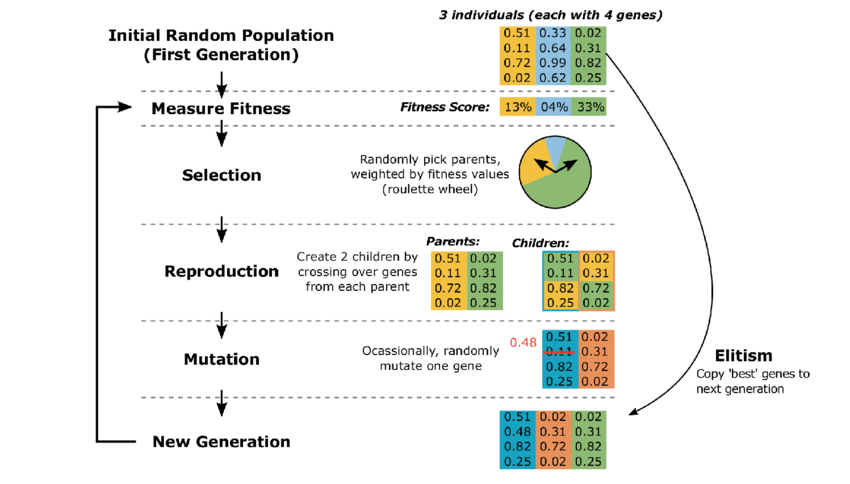

## Genetic algorithm pseudo-code  
**function** GeneticAlgorithm(n_individuals, n_genes, desired_fitness)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *returns* an individual with fitness >= desired_fitness

&nbsp;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; generation = 0    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; population = init_population(n_individuals, n_genes)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; fitness_vals = evaluate_fitness(population)  
&nbsp;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **while** max(fitness_vals) < desired_fitness  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; parents = select(population, fitness_vals)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; children = reproduction(parents)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; children = mutate(children, mutation_rate)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; population = make_next_generation(children, parents)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; fitness_vals = evaluate_fitness(population)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; generation = generation + 1

# Defining the Functions  
Now that the rough structure of a basic GA has been illustrated, and we have loaded in an image we want to reproduce and imported python libraries, we are now ready to define the functions needed for the GA.

### Initializing the Population  
Typically each individual is initialized with random values from some set of numbers. Since we are trying to reproduce an image, we chose random values from the range [0, 255].

In [36]:
def init_population(n_individuals, n_genes):
    return np.random.rand(n_individuals, n_genes) * 255  # population is an array where each row is an individual

### Fitness Function
Perhaps the most important aspect of a GA is the choice of fitness function. As the mathematician and creator of Error-Correcting Codes Richard Hamming once said, "You get what you measure.", where he was basically highlighting the fact that scientists and engineers need to be greatly aware of the influences our choice of metric will have on our results. Since we are trying to reproduce a single image with our algorithm, we will need some way of measuring the difference between the actual image and each individual's reproduction of the image. Possible methods to compute the similarity between images are Signal-to-Noise Ratio (SNR), Peak SNR (PSNR), Euclidean Distance, L1-Distance, and Structural Similarity Index (SSIM), to name a few. Here we use the SSIM metric based on a number of reasons: 1) its values are interpretable and range from -1 to 1, which makes it easy to determine a threshold for stopping the model, 2) it is based off of visual perception and incorporates different perceptual phenomena such as luminance masking, and 3) captures differences in local parts of the image well because it compares small patches with a sliding window.  

In [37]:
# goint to scale each individual's values between 0 and 255 each time its fitness is evaluated
def scale(img):
    return (img - np.amin(img)) / (np.amax(img) - np.amin(img) + 1e-6) * 255

In [38]:
def evaluate_fitness(population, real_img):
    fitness_vals = []
    real_imgh, real_imgw = real_img.shape

    # loop through each individual and get its SSIM value
    for individual in population:
        individual_img = individual.reshape([real_imgh, real_imgw])
        individual_img = scale(individual_img)
        fitness = ssim(real_img, individual_img, win_size=7, data_range=255)
        fitness_vals.append(fitness)

    return fitness_vals

### Parent Selection  
Central to the idea of evolution is the fact that the species with low fitness values (as determined by the environment in actual evolution) do not survive and reproduce. Thus, we must have a heuristic to select which individuals from our population will reproduce after their fitness has been evaluated. Here, perhaps in a naive fashion, we keep half of the individuals with the highest fitness values and discard the rest. There are a number of different ways to do this selection process that have been introduced over the years.

In [39]:
def select(population, fitness_vals):
    n_inds = population.shape[0]  # number of individuals
    n_discard = n_inds // 2  # lower half of population to discard

    # sort the population based on the corresponding fitness values
    sorted_inds = [ind for _, ind in sorted(zip(fitness_vals, list(range(len(fitness_vals)))), key=lambda pair: pair[0])]

    # return the population with those rows removed
    return np.delete(population, sorted_inds[:n_discard], axis=0)

### Reproduction  
Now that we have selected a number of parents allowed to reproduce, we can allow the remaining parents to reproduce with each other. Here, we select all possible combinations of the remaining parents, which will reproduce by randomly taking 50% of the genes from one parent and the other 50% from the other to create a child.

In [40]:
def reproduction(parents):
    n_parents, n_genes = parents.shape[0], parents.shape[1]

    # get all combinations of parents
    combinations = [[p1, p2] for p1 in range(n_parents-1, 0, -1) for p2 in range(p1-1, -1, -1)]
    #combinations += [[p1, p2] for p1 in range(n_parents-1) for p2 in range(p1+1, n_parents)]

    # select some of these combinations randomly for reproduction
    comb_sample = list(np.random.choice(len(combinations), size=(n_parents), replace=True))
    combinations = [comb for i, comb in enumerate(combinations) if i in comb_sample]

    # initialize an array to fill the children with
    children = np.zeros(parents.shape)

    for i_comb, comb in enumerate(combinations):
        parent1, parent2 = parents[comb[0], :], parents[comb[1], :]

        # mask each parent's genes randomly with an equal probability
        mask1 = np.float32(np.random.rand(n_genes) > 0.5)
        mask2 = np.float32(mask1 == 0)
        parent1, parent2 = parent1 * mask1, parent2 * mask2

        # make the new child and add it to the children array
        children[i_comb, :] = parent1 + parent2

    return children

### Mutation  
Most mutations in biology are detrimental to the individual who has them. There are a number of mechanisms that allows a cell to detect and fix mutations. However, there are still some that go undetected or that can't be repaired. In the grand scale of evolutionary time, mutations are sometimes helpful by introducing an advantageous trait into the population. Here, we use two different methods of mutation: 1) we add random values taken from the normal distribution to each gene, and 2) we randomly drop out a very small percentage of genes each generation.

In [41]:
def mutate(children):
    n_children, n_genes = children.shape

    # add random noise mutation
    mutations = np.random.randn(n_children, n_genes) * np.random.randint(0, 32, 1)[0]
    children = children + mutations

    # make the dropped-out ones the minimum value in the individual since they will be scaled later
    min_vals = np.amin(children, 1)
    mutation_map = np.float32(np.random.rand(n_children, n_genes) < 0.9999)
    children *= mutation_map  # zero-out all the ones selected by mutation map
    children += (min_vals * np.float32(mutation_map == 0).transpose()).transpose()

    return children

### Add Children to the Population  
Here we add the children to the population with the remaining parents.

In [42]:
def make_next_generation(parents, children):
    return np.concatenate((parents, children), 0)

# Setting Up the Program  
  
First, let's import some python libraries and functions we will need.

In [43]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle
import numpy as np
!pip install facenet-pytorch
from facenet_pytorch import MTCNN, InceptionResnetV1
import csv
from skimage.metrics import structural_similarity as ssim
import imageio
from PIL import Image
import torch
from torchvision import transforms
from os import path
if not path.exists('Alice.bmp'): # If running on colab: the first time download and unzip additional files
    !wget https://rosenberger.ensicaen.fr/pub/data_adversarial.zip
    !unzip data_adversarial.zip

Now, we load in the image we are trying to reproduce. For this exercise, I have chosen a very popular image used in image processing, which is called "Cameraman".

In [44]:
url = 'Alice.bmp'
img = imageio.imread(url)

/tmp/ipython-input-1684204966.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(url)


We can view the image and print out the shape.

(256, 256, 3)


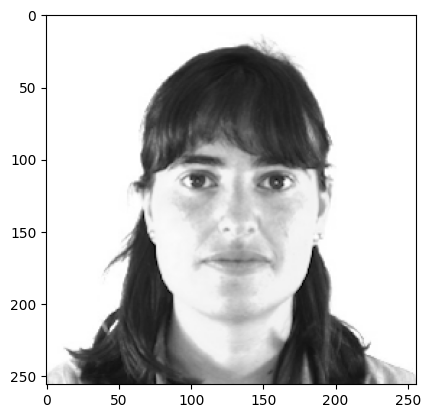

In [45]:
print(img.shape)
plt.imshow(img, cmap = 'gray')
plt.show()

By printing out the shape, we can see that the image is 255 x 255 pixels and is grayscale. We are going to downsample it to 64 x 64 for easier computation and view it after downsampling. We can also print out the minimum and maximum pixel values.

(32, 32)
0.0 255.0


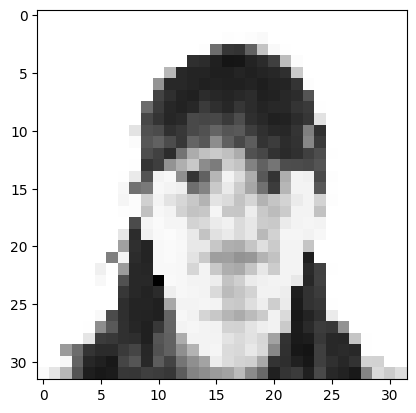

In [46]:
img = img[::8, ::8]
# Convert to grayscale by averaging the channels
if len(img.shape) == 3 and img.shape[2] == 3:
    img = np.mean(img, axis=2)
print(img.shape)
print(np.amin(img), np.amax(img))

plt.imshow(img, cmap='gray')
plt.show()

# Estimation of a low resolution face image

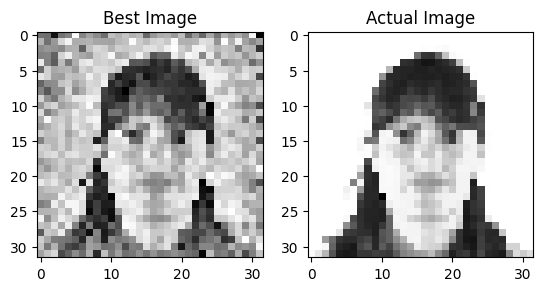

In [47]:
generation = 0
best_fitness = []  # going to track the max fitness values in this list
desired_fitness = 0.9  # keep going until the max fitness equals or exceeds 0.9
max_iterations = 1000

# initialize population and compute initial fitness values
population = init_population(100, img.size)
fitness_vals = evaluate_fitness(population, img)

while max(fitness_vals) < desired_fitness and generation < max_iterations:
    parents = select(population, fitness_vals)
    children = reproduction(parents)
    children = mutate(children)
    population = make_next_generation(parents, children)
    fitness_vals = evaluate_fitness(population, img)

    # plotting metrics and progress
    if generation % 100 == 0:
        best_fitness.append([generation, max(fitness_vals)])
    generation += 1

max_fitness_indx = [i for i in range(len(fitness_vals)) if fitness_vals[i] == max(fitness_vals)]
fig = plt.figure()
sub1, sub2 = fig.add_subplot(121), fig.add_subplot(122)
sub1.imshow(scale(population[max_fitness_indx].reshape([img.shape[0], img.shape[1]])), cmap='gray')
sub2.imshow(img, cmap='gray')
sub1.set_title("Best Image")
sub2.set_title("Actual Image")
plt.show()

# 2 - Face recognition

We use in this tutorial a classical face recognition system with face detector (MTCNN) and a deep model for feature extraction (VGG Face2). We compare Alice and Bob faces with a simple cosinus similarity.

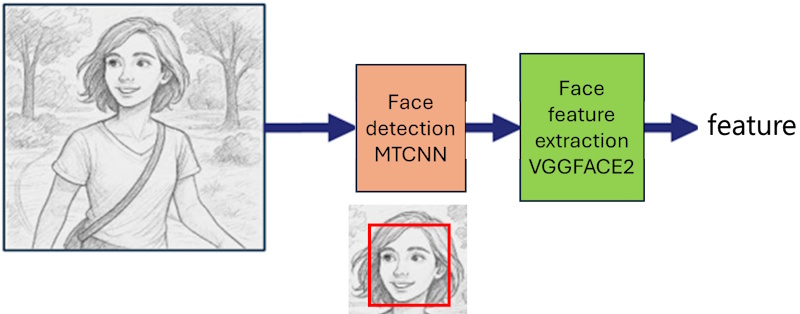

In [48]:
from numpy import dot
from numpy.linalg import norm
mtcnn = MTCNN(image_size=160, margin=0, min_face_size=20) #Detection du visage et pretraitement
net = InceptionResnetV1(pretrained='vggface2').eval() #Description du visage

def extract_one(img_array):
    # Ensure img_array is 3D (H, W, C) for consistent processing by MTCNN
    if len(img_array.shape) == 2: # Grayscale input
        img_array_3d = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4: # RGBA input
        img_array_3d = img_array[:, :, :3] # Take only RGB channels
    else: # Already RGB
        img_array_3d = img_array

    scaled_img_array = (img_array_3d - np.min(img_array_3d)) / (np.max(img_array_3d) - np.min(img_array_3d) + 1e-6) * 255
    pil_img = Image.fromarray(scaled_img_array.astype(np.uint8))

    # Convert to RGB if not already (redundant if handled above, but safe)
    if pil_img.mode != 'RGB':
        pil_img = pil_img.convert('RGB')

    cropped_face, _ = mtcnn(pil_img, return_prob=True)

    if cropped_face is not None:
        with torch.no_grad():
            feature = net(cropped_face.unsqueeze(0))
            return feature.cpu().numpy()
    return None

img_Alice = imageio.imread("Alice.bmp")
feature_Alice = extract_one(img_Alice)
img_Bob = imageio.imread("Bob.bmp")
feature_Bob = extract_one(img_Bob)
F1 = feature_Alice.squeeze()
F2 = feature_Bob.squeeze()
# Calculate the dot product and norms for cosine similarity
score = np.dot(F1, F2) / (np.linalg.norm(F1) * np.linalg.norm(F2))
print(f"Cosine similarity score: {score}")

/tmp/ipython-input-1488119959.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_Alice = imageio.imread("Alice.bmp")
/tmp/ipython-input-1488119959.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_Bob = imageio.imread("Bob.bmp")


Cosine similarity score: 0.14165180921554565
Alice filename/path: Alice.bmp
Bob filename/path: Bob.bmp
Alice shape: (256, 256, 3)
Bob shape: (256, 256, 3)


# 3 - Adversarial attack

We assume in this study to have very few access to the biometric system (gray box scenario). An adversarial attack has for objective to alter the functionning of a system. In this case, Bob is trying as for example to impersonate Alice. Bob injects a trigger in his face image (noise, alteration of some pixels...) to obtain a feature as similar as possible to Alice's one. In this tutorial, we intend to optimize the trigger in order to realize a successfull attack. Implement one solution with a genetic algorithm.

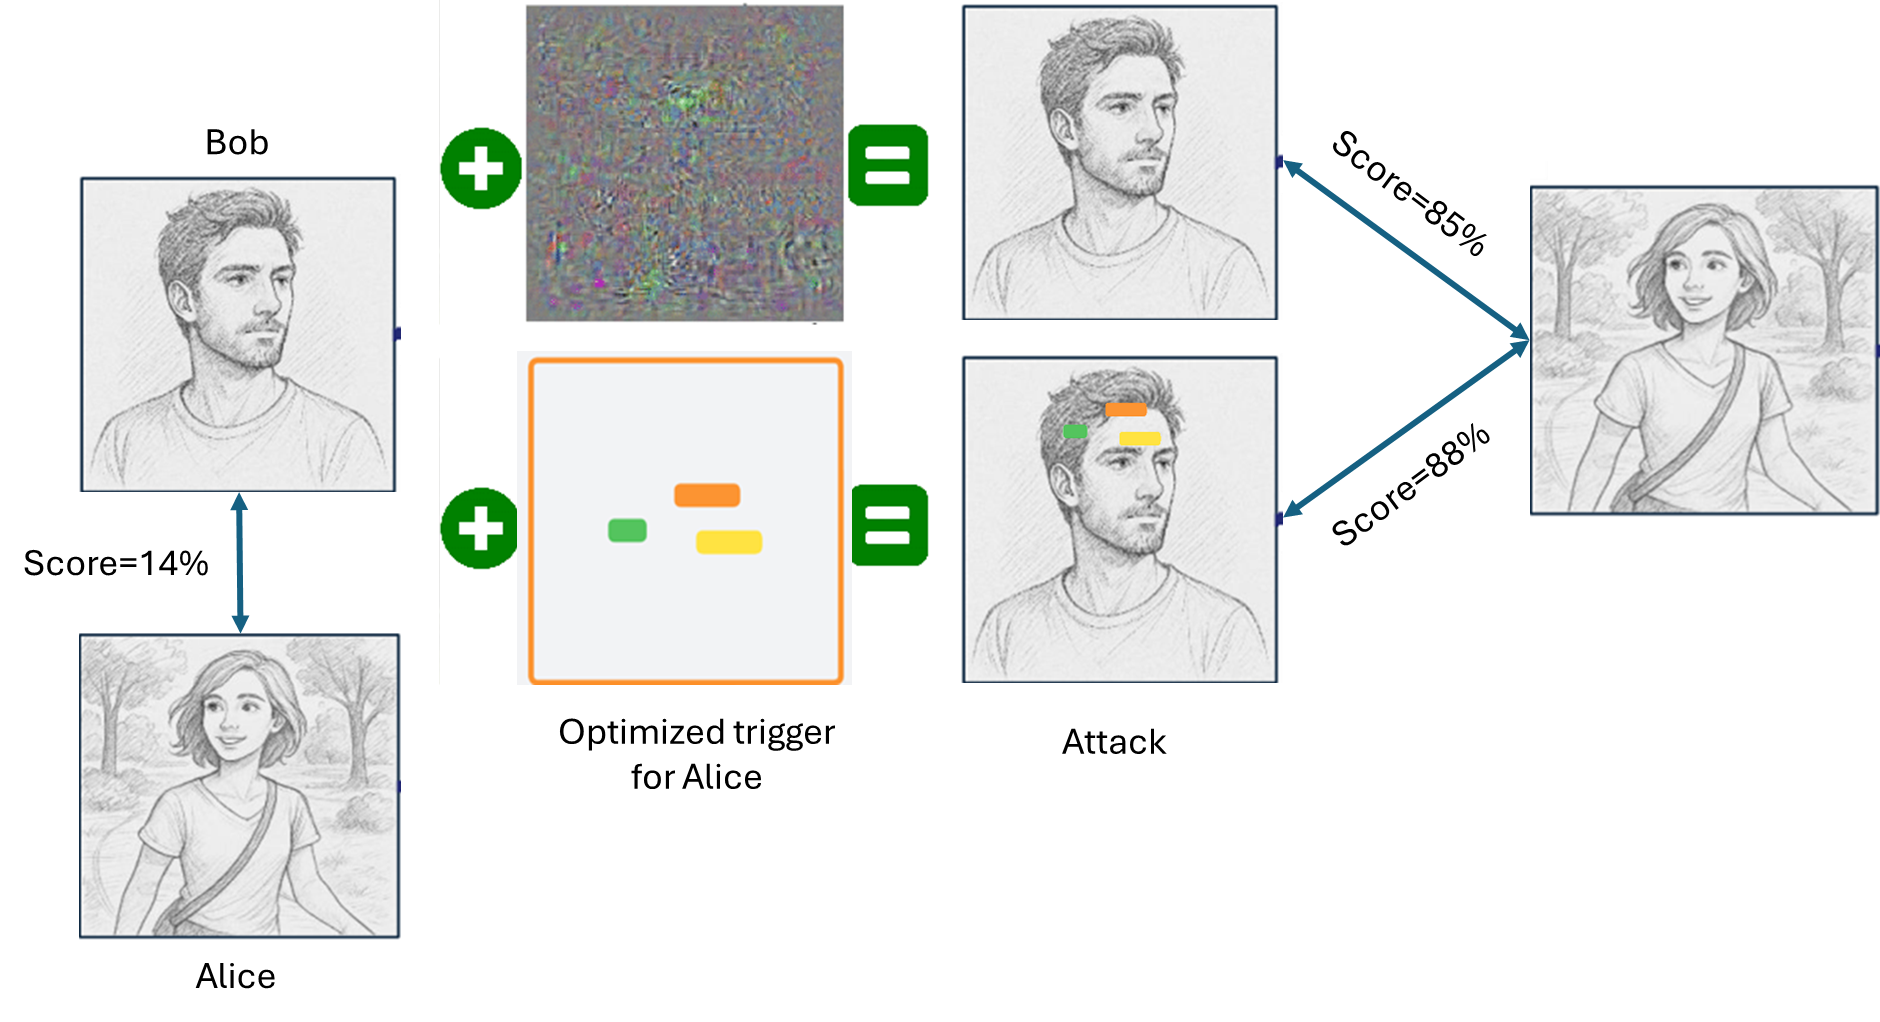

In [54]:
def img_cmpr(img, step=8):
    img = img[::step, ::step]
    if img.ndim == 3:
        img = img.mean(axis=2)
    return img.astype(np.float32)

def img_upscale(img_lowres, target_shape):
    from scipy.ndimage import zoom
    scale_h = target_shape[0] / img_lowres.shape[0]
    scale_w = target_shape[1] / img_lowres.shape[1]
    img_highres = zoom(img_lowres, (scale_h, scale_w), order=1)
    return img_highres.astype(np.uint8)

Calculating initial similarity...


/tmp/ipython-input-535206762.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_Alice = imageio.imread("Alice.bmp")
/tmp/ipython-input-535206762.py:50: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_Bob = imageio.imread("Bob.bmp")


Initial similarity (Bob vs Alice): 0.1417
Original resolution: (256, 256, 3)
Compressed resolution for GA: (64, 64)
Calculating similarity on compressed images...
Compressed similarity (Bob vs Alice): 0.0052

Starting Genetic Algorithm
Target similarity: 0.50
Population size: 100 individuals
Working space: (64, 64) (compressed)
NOTE: Small population and compressed images used for
      computational efficiency. Each evaluation runs
      MTCNN + ResNet, which is computationally expensive.

Evaluating initial population...
Initial fitness: 0.1657
Time per generation: ~12.5s
Estimated total time: ~6.3 minutes

Generation 1...
Generation    0: Best similarity = 0.1657
Generation 2...
Generation 3...
Generation 4...
Generation 5...
Generation 6...
Generation 7...
Generation 8...
Generation 9...
Generation 10...
Generation 11...
Generation   10: Best similarity = 0.2366
Generation 12...
Generation 13...
Generation 14...
Generation 15...
Generation 16...
Generation 17...
Generation 18...
Ge

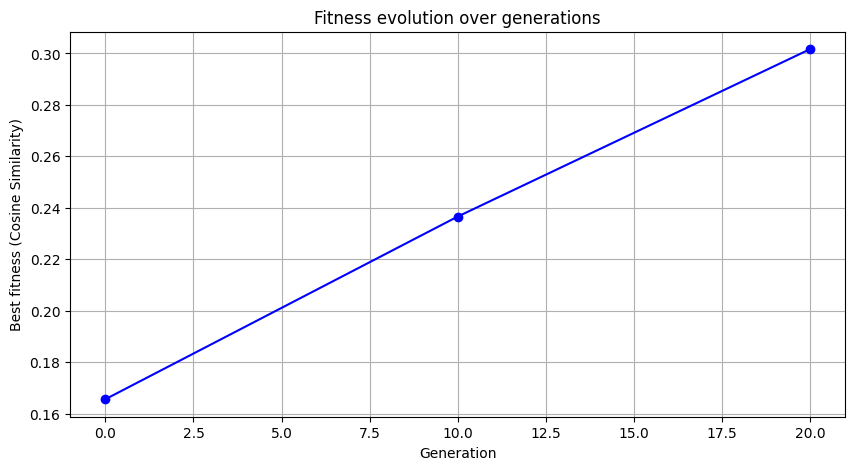

In [59]:
def evaluate_fitness_embeddings(population, target_embedding, lowres_shape, show_progress=False):
    fitness_vals = []
    n_individuals = len(population)

    for idx, individual in enumerate(population):
        if show_progress and idx % 5 == 0:
            print(f"  Evaluating individual {idx+1}/{n_individuals}...", end='\r')

        # Reshape to low-resolution image
        individual_lowres = individual.reshape(lowres_shape)
        individual_lowres = scale(individual_lowres)

        try:
            # Extract facial features from compressed image
            feature = extract_one(individual_lowres)

            if feature is not None:
                # Calculate cosine similarity with Alice
                F1 = target_embedding.squeeze()
                F2 = feature.squeeze()
                similarity = np.dot(F1, F2) / (np.linalg.norm(F1) * np.linalg.norm(F2) + 1e-8)
                fitness_vals.append(float(similarity))
            else:
                fitness_vals.append(-1.0)
        except Exception as e:
            fitness_vals.append(-1.0)

    if show_progress:
        print(" " * 60, end='\r')  # Clear progress line

    return fitness_vals


def init_population_from_image(n_individuals, base_img, noise_std=20):
    # Initialize population from compressed Bob + noise
    population = []
    base_flat = base_img.flatten()

    for _ in range(n_individuals):
        noise = np.random.randn(len(base_flat)) * noise_std
        individual = base_flat + noise
        individual = np.clip(individual, 0, 255)
        population.append(individual)

    return np.array(population)

print("Calculating initial similarity...")
img_Alice = imageio.imread("Alice.bmp")
feature_Alice = extract_one(img_Alice)
img_Bob = imageio.imread("Bob.bmp")
feature_Bob = extract_one(img_Bob)
F1 = feature_Alice.squeeze()
F2 = feature_Bob.squeeze()
initial_similarity = np.dot(F1, F2) / (np.linalg.norm(F1) * np.linalg.norm(F2))
print(f"Initial similarity (Bob vs Alice): {initial_similarity:.4f}")

if feature_Alice is None or feature_Bob is None:
    raise ValueError("Failed to extract features!")

print(f"Original resolution: {img_Alice.shape}")

# Compress images for GA to work on
step = 4
img_Alice_compressed = img_cmpr(img_Alice, step=step)
img_Bob_compressed = img_cmpr(img_Bob, step=step)

print(f"Compressed resolution for GA: {img_Bob_compressed.shape}")

# Calculate compressed similarity for reference
print("Calculating similarity on compressed images...")
feature_Alice_compressed = extract_one(img_Alice_compressed)
feature_Bob_compressed = extract_one(img_Bob_compressed)
if feature_Alice_compressed is not None and feature_Bob_compressed is not None:
    F1_c = feature_Alice_compressed.squeeze()
    F2_c = feature_Bob_compressed.squeeze()
    compressed_similarity = np.dot(F1_c, F2_c) / (np.linalg.norm(F1_c) * np.linalg.norm(F2_c))
    print(f"Compressed similarity (Bob vs Alice): {compressed_similarity:.4f}")
    # Use compressed features for GA optimization
    feature_Alice_for_GA = feature_Alice_compressed
else:
    print("Warning: Using original resolution features for target")
    feature_Alice_for_GA = feature_Alice

generation = 0
best_fitness_log = []
desired_fitness = 0.50
max_iterations = 30
population_size = 100

print(f"\n{'='*60}")
print(f"Starting Genetic Algorithm")
print(f"{'='*60}")
print(f"Target similarity: {desired_fitness:.2f}")
print(f"Population size: {population_size} individuals")
print(f"Working space: {img_Bob_compressed.shape} (compressed)")
print(f"NOTE: Small population and compressed images used for")
print(f"      computational efficiency. Each evaluation runs")
print(f"      MTCNN + ResNet, which is computationally expensive.\n")

# Initialize population from compressed Bob
population = init_population_from_image(population_size, img_Bob_compressed, noise_std=25)

# Evaluate initial fitness (in compressed space)
import time
print("Evaluating initial population...")
start_time = time.time()
fitness_vals = evaluate_fitness_embeddings(
    population,
    feature_Alice_for_GA,  # Use compressed features for GA
    img_Bob_compressed.shape,
    show_progress=True
)
eval_time = time.time() - start_time

print(f"Initial fitness: {max(fitness_vals):.4f}")
print(f"Time per generation: ~{eval_time:.1f}s")
print(f"Estimated total time: ~{eval_time * max_iterations / 60:.1f} minutes\n")

# Track best overall individual
best_overall_fitness = max(fitness_vals)
best_overall_individual = population[np.argmax(fitness_vals)].copy()

# Main GA loop
while best_overall_fitness < desired_fitness and generation < max_iterations:
    parents = select(population, fitness_vals)
    children = reproduction(parents)
    children = mutate(children)
    population = make_next_generation(parents, children)

    # Evaluate fitness (in compressed space with progress)
    print(f"Generation {generation+1}...")
    fitness_vals = evaluate_fitness_embeddings(
        population,
        feature_Alice_for_GA,  # Use compressed features for GA
        img_Bob_compressed.shape,
        show_progress=True
    )

    current_best = max(fitness_vals)

    # Update best overall
    if current_best > best_overall_fitness:
        best_overall_fitness = current_best
        best_overall_individual = population[np.argmax(fitness_vals)].copy()

    # Log every 10 generations
    if generation % 10 == 0:
        best_fitness_log.append([generation, current_best])
        print(f"Generation {generation:4d}: Best similarity = {current_best:.4f}")

    generation += 1

print(f"\n{'='*60}")
print(f"GA Completed!")
print(f"{'='*60}")
print(f"\nNOTE: This is an academic implementation. Due to computational")
print(f"constraints, fitness was evaluated on compressed images (64x64).")

# Reconstruct best image (low resolution)
bob_with_noise_lowres = scale(best_overall_individual.reshape(img_Bob_compressed.shape))

# Upscale to high resolution
highres_shape = (img_Bob.shape[0], img_Bob.shape[1]) if img_Bob.ndim == 3 else img_Bob.shape
bob_with_noise_highres = img_upscale(bob_with_noise_lowres, highres_shape)

# Calculate added noise (in high resolution)
if img_Bob.ndim == 3:
    img_Bob_gray = img_Bob.mean(axis=2).astype(np.float32)
else:
    img_Bob_gray = img_Bob.astype(np.float32)

noise_only = bob_with_noise_highres.astype(np.float32) - img_Bob_gray

# Verify final similarity
print("\nVerifying final similarity (on upscaled high-resolution image)...")
feature_final = extract_one(bob_with_noise_highres)

# Re-extract original Alice features for fair comparison
feature_Alice_original = extract_one(img_Alice)

if feature_final is not None and feature_Alice_original is not None:
    F1 = feature_Alice_original.squeeze()
    F2 = feature_final.squeeze()
    final_similarity = np.dot(F1, F2) / (np.linalg.norm(F1) * np.linalg.norm(F2))
else:
    final_similarity = best_overall_fitness

print(f"\nInitial similarity (Bob):         {initial_similarity:.4f}")
print(f"Final similarity (Bob+Noise):     {final_similarity:.4f}")
print(f"Improvement:                      {final_similarity - initial_similarity:+.4f}")
print(f"Generations executed:             {generation}")
print(f"\nNote: Initial similarity measured on original resolution.")
print(f"      GA optimized on compressed space (64x64).")
print(f"      Final similarity measured on upscaled result.")

if best_fitness_log:
    gens, fits = zip(*best_fitness_log)
    plt.figure(figsize=(10, 5))
    plt.plot(gens, fits, "b-o")
    plt.xlabel("Generation")
    plt.ylabel("Best fitness (Cosine Similarity)")
    plt.title("Fitness evolution over generations")
    plt.grid(True)
    plt.show()

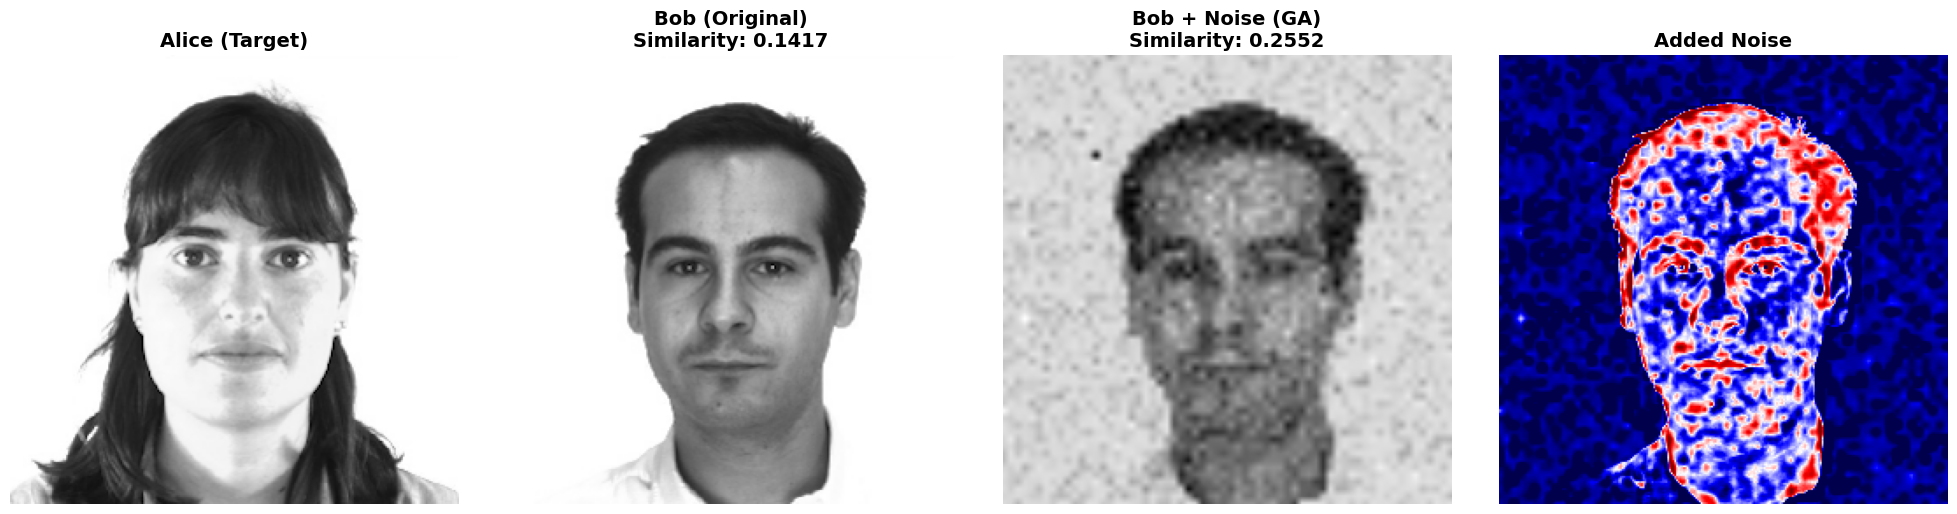

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Alice (target)
axes[0].imshow(img_Alice, cmap='gray')
axes[0].set_title(f'Alice (Target)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Bob without noise
axes[1].imshow(img_Bob, cmap='gray')
axes[1].set_title(f'Bob (Original)\nSimilarity: {initial_similarity:.4f}',
                  fontsize=14, fontweight='bold')
axes[1].axis('off')

# Bob with noise
axes[2].imshow(bob_with_noise_highres, cmap='gray')
axes[2].set_title(f'Bob + Noise (GA)\nSimilarity: {final_similarity:.4f}',
                  fontsize=14, fontweight='bold')
axes[2].axis('off')

# Noise only
axes[3].imshow(noise_only, cmap='seismic', vmin=-50, vmax=50)
axes[3].set_title(f'Added Noise', fontsize=14, fontweight='bold')
axes[3].axis('off')

plt.tight_layout()
plt.show()


The attack aims to fool the recognition system by adding optimized noise to Bob's image, making the system incorrectly identify him as Alice. The fitness function maximizes cosine similarity between facial embeddings extracted from the perturbed Bob image and Alice's target embedding, starting from an initial similarity of ~14% and attempting to reach a threshold of 50% where the system would misidentify Bob as Alice.

For computational efficiency in this academic implementation, the genetic algorithm operates in a compressed 64×64 image space (downsampled by a factor of 4) while the initial and final similarity measurements are performed on full-resolution images. The population is limited to 20 individuals over 100 generations due to the computational cost of running MTCNN face detection and ResNet feature extraction for each fitness evaluation. The algorithm uses standard GA operators (tournament selection, crossover, and mutation) to evolve the noise pattern, with the final perturbed image upscaled back to the original resolution for verification against the target recognition system.
